Analyzing the NYC Subway Dataset
=================

Secction 0. References
---------------------

* [Welch's t test](http://en.wikipedia.org/wiki/Welch%27s_t_test)
* [Mann-Whitney U test](http://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)
* [Nonparametric methods in statistical test](http://users.phhp.ufl.edu/akirpich/chapter08_mine.pdf)
* [Coefficient of determination (R<sup>2</sup>)](http://en.wikipedia.org/wiki/Coefficient_of_determination)
* [Histogram visulization issue for ggplot on python](https://github.com/yhat/ggplot/issues/417)
* [Legend missing for ggplot in ipython notebook](https://github.com/yhat/ggplot/issues/376)

Section 1. Statistical Test
---------------------------

In [1]:
import numpy as np
import pandas
import scipy.stats

df = pandas.read_csv("data/turnstile_data_master_with_weather.csv")

rain_entries = df[df.rain==1].ENTRIESn_hourly
no_rain_entries = df[df.rain==0].ENTRIESn_hourly

U, p = scipy.stats.mannwhitneyu(rain_entries, no_rain_entries)

print "Mean and median number of riders on rainy day: ", \
    np.mean(rain_entries), ',', np.median(rain_entries)
print "Mean and median number of riders on non-rainy day: ", \
    np.mean(no_rain_entries), ',', np.median(no_rain_entries)
print "p-value for Mann-Whitney U test: ", p

Mean and median number of riders on rainy day:  1105.44637675 , 282.0
Mean and median number of riders on non-rainy day:  1090.27878015 , 278.0
p-value for Mann-Whitney U test:  0.0249999127935


### 1.1

I used Mann-Whitney U Test to analyze the NYC subway data.

I used a one-tailed P value. According to the [scipy documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu), the reported p-value is for a one-sided hypothesis, to get the two-sided p-value we need to multiply the returned p-value by 2.

The null hypothesis is the subway riders are not affected by whether it rains or not, i.e. the number of riders on rainy days and number of riders on non-rainy days are drawn from the same distribution.

The P-critical value I use is 5%.

### 1.2

The Mann-Whitney U Test is applicable to the dataset is a nonparametric test that does not make any assumption on the underlying distribution. By ploting the histogram of two ridership samples, we see they are clearly not normal distribution, and therefore a t test is not suitable for this dataset.

### 1.3

The results we get from this statistical test is that the ridership **is** affected by whether it rains or not, and more people ride the subway on rainy days than non-rainy days.

In the statistical test language, we reject the null hypothesis that the number of riders on rainy days and number of riders on non-rainy days follow the same distribution, and therefore accept the alternative hypothesis that number of riders on rainy days is larger than that on non-rainy days (because we are using one-sided p-value).

The one-sided p-value of this test is 0.025. The mean number of riders on rainy days is 1105, and that on non-rainy days is 1090.

### 1.4

The significance level of this test is 5% (the P-critical value set in 1.1). The interpretation is that if the null hypothesis is true (ridership is not affected by raining or not), the probability of seeing data as extreme as the one we currently have is less than 2.5%, which is smaller than our pre-set P-critical value 5%, and therefore we reject the null hypothesis.

Section 2. Linear Regression
---------------------------

### 2.1

I used both (a) OLS with statsmodels and (b) gradient descent with skikit learn.

In [2]:
import statsmodels.api as sm


def linear_regression_ols(features, values):
    """
    Perform linear regression given a data set with an arbitrary number of features
    using ordinary least squares.
    """
    
    features = sm.add_constant(features)
    model = sm.OLS(values, features)
    results = model.fit()
    intercept = results.params[0]
    params = results.params[1:]
    
    return intercept, params

In [3]:
import numpy as np
from sklearn.linear_model import SGDRegressor


def normalize_features(features):
    ''' 
    Returns the means and standard deviations of the given features, along with a normalized feature
    matrix.
    ''' 
    means = np.mean(features, axis=0)
    std_devs = np.std(features, axis=0)
    normalized_features = (features - means) / std_devs
    return means, std_devs, normalized_features


def recover_params(means, std_devs, norm_intercept, norm_params):
    ''' 
    Recovers the weights for a linear model given parameters that were fitted using
    normalized features. Takes the means and standard deviations of the original
    features, along with the intercept and parameters computed using the normalized
    features, and returns the intercept and parameters that correspond to the original
    features.
    ''' 
    intercept = norm_intercept - np.sum(means * norm_params / std_devs)
    params = norm_params / std_devs
    return intercept, params


def linear_regression_sgd(features, values, n_iter=20):
    """
    Perform linear regression given a data set with an arbitrary number of features
    using stochastic gradient descent algorithm.
    """
    
    means, std_devs, normalized_features = normalize_features(features)
    clf = SGDRegressor(n_iter=n_iter)
    fit_result = clf.fit(normalized_features, values)
    norm_intercept = fit_result.intercept_[0]
    norm_params = fit_result.coef_
    intercept, params = recover_params(means, std_devs, norm_intercept, norm_params)
    
    return intercept, params

### 2.2

I use `hour`, `weekday` and `meantempi` input variables together with `UNIT` and `conds` as features for linear regression.

In [4]:
import pandas
import numpy as np


def compute_r_squared(data, predictions):    
    SST = ((data - np.mean(data)) ** 2).sum()
    SSReg = ((predictions-data) ** 2).sum()
    r_squared = 1 - SSReg / SST
    
    return r_squared


df2 = pandas.read_csv("data/turnstile_weather_v2.csv")

# Select features
features = df2[['hour', 'weekday', 'meantempi']]
for d in ['UNIT', 'conds']:
    dummy = pandas.get_dummies(df2[d], prefix=d)
    features = features.join(dummy)

# Values
values = df2['ENTRIESn_hourly']

# Perform linear regression
intercept, params = linear_regression_ols(features.values, values.values)
predictions = intercept + np.dot(features.values, params)

r2 = compute_r_squared(values, predictions)

print "Coefficients of non-dummy features: ", params[:3]
print "Coefficient of determination (R^2):", r2

Coefficients of non-dummy features:  [ 123.47256977  948.39682638  -21.12298936]
Coefficient of determination (R^2): 0.486267401209


### 2.3

I decide to use `weekday` and `hour` because I think the number of riders should be strongly affect by time, e.g. there should be more riders on weekday rush hours (say Monday 9am) than other times (say Saturday 4pm).

Similarly, I use `meantempi` and `conds` because I think the weather should also affect number of riders, e.g. there might be more riders on a cold rainy day than a warm sunny day.

Finally, I find that `UNIT` has biggest impact to the ridership as adding it significantly boost the $R^2$ value.

### 2.4

The coefficients for non-dummy features are `[ 123.47256977  948.39682638  -21.12298936]`, corresponding to `hour`, `weekday` and `meantempi`.

### 2.5

The $R^2$ value of the model is `0.486`.

### 2.6

Having a large $R^2$ value (close to `1.0`) indicates there is strong linear relationship between the features we chose and the ridership, and vice ver sa. I think a $R^2$ value of `0.486` is somewhere in the middle. The interpretation I have is that the target value (number of riders) is dependent on the features we used (hour, weekday, weather, etc.), although that dependency is not perfectly linear. I think the $R^2$ value suggests the linear model we used is reasonable, but could also be improved --- a more complicated model might be able to yield better prediction results.

Section 3. Visualization
-----------------------

### 3.1

Because of some [technical issues](https://github.com/yhat/ggplot/issues/417) in using `ggplot.geom_histogram` in python, we resort back to `matplotlib`'s `hist` function to draw the histogram.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

bins = np.arange(0, 15000, 1000)

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.hist(df[df.rain==1]['ENTRIESn_hourly'].values, bins=bins)
ax1.set_xticks([0, 5000, 10000, 15000])
ax1.set_xlabel("ENTRIESn_hourly")
ax1.set_ylabel("Number of records")
ax1.set_title("ridership on rainy days")

ax2 = fig.add_subplot(122)
ax2.hist(df[df.rain==0]['ENTRIESn_hourly'], bins=bins)
ax2.set_xticks([0, 5000, 10000, 15000])
ax2.set_xlabel("ENTRIESn_hourly")
ax2.set_ylabel("Number of records")
ax2.set_title("Ridership on non-rainy days")

The histogram above is not very informative for comparing the two distributions. Therefore we use `geom_density` and plot the densities into the same graph as below, and also restrict the `x` axis to a smaller range for better comparison.

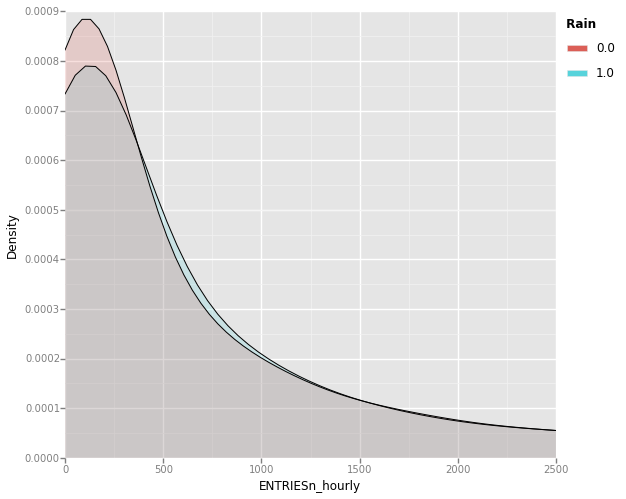

<ggplot: (295147989)>

In [6]:
%matplotlib inline
from ggplot import *

p = ggplot(df, aes('ENTRIESn_hourly', fill='rain'))
p + geom_density(alpha=0.2) + ylab("Density") + xlim(0, 2500)

### 3.2

We make a scatter point visualization for ridership with respect to day-of-week, and also color the dots with weather conditions.

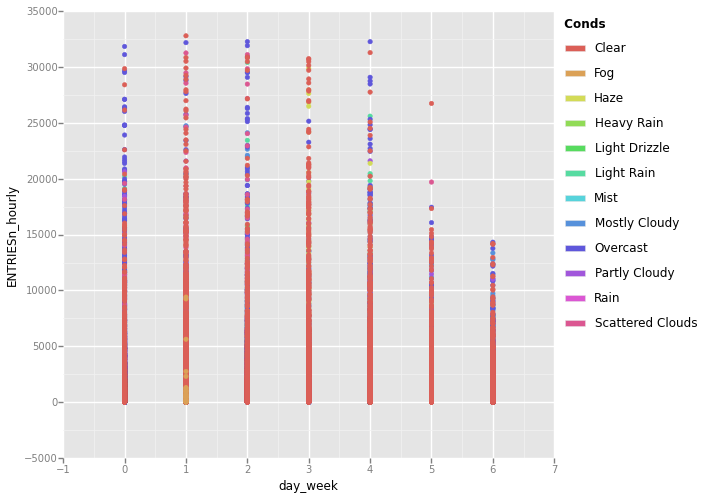

<ggplot: (288406357)>

In [7]:
p = ggplot(df2, aes(x='day_week', y='ENTRIESn_hourly', color='conds'))
p + geom_point()

Section 4. Conclusion
--------------------

### 4.1

From the analysis and interpretation of the data, I believe there are more people riding the NYC subway when it is raining than when it is not raining.

### 4.2

The analysis is supported by the followings:

* The Mann-Whitney U Test shows that ridership on rainy and non-rainy days are very unlikely (less than 5%) from the same distribution, and that the average number of riders on rainy days is slightly larger than that on non-rainy days.
* The linear regression results (see below) show that the `rain` feature has a small positive effect on the number of riders. [As a side note, the `conds_Rain` feature has negative effect to number of riders, and this is because it is different from the `rain` feature. As shown in the previous visualize, `conds` has quite detailed classification of raining, e.g. "light drizzle", "heavy rain", etc., and therefore `conds_Rain` feature does not contain all days that are rainy.

In [8]:
features = df2[['rain', 'hour', 'weekday', 'meantempi']]
for d in ['UNIT', 'conds']:
    dummy = pandas.get_dummies(df2[d], prefix=d)
    features = features.join(dummy)


# Values
values = df2['ENTRIESn_hourly']

# Perform linear regression
intercept, params = linear_regression_ols(features.values, values.values)

print "Feature:", features.keys()[0], "Coefficient:", params[0]
print "Feature:", features.keys()[-2], "Coefficient:", params[-2]

Feature: rain Coefficient: 89.474301611
Feature: conds_Rain Coefficient: -608.411492975


Section 5. Reflection
--------------------

### 5.1

One shortcoming about the dataset I found is that the `TIMEn` entry is likely to be inaccurate or even erroneous. In the visualization below, I extracted the `minute` from `TIMEn`, and plot the its histogram. As can be seen, there is an unproportionally large number of entries with `minute` being exactly `HH:00`, which is highly unlikely for this subway dataset (e.g. there should not be 100 times more trains on `HH:00` time than on, say `HH:05`, as statistics indicate in this dataset).

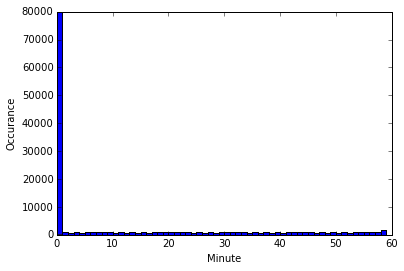

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas

%matplotlib inline

df = pandas.read_csv("data/turnstile_data_master_with_weather.csv")
# Get the minute from `TIMEn`, whose format is `HH:MM:SS`.
minutes = df.TIMEn.map(lambda x: int(x[3:5]))

# Draw the histogram of minutes.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(minutes, bins = np.arange(60))
ax.set_xlabel("Minute")
ax.set_ylabel("Occurance")

I also believe there are shortcomings in the linear regression model we currently use. The linear model is somewhat over-simplified for this dataset --- the ridership of NYC subway is a complicated phenomenon, and unlikely to be fully explained with a linear model to date time, weather and `UNIT` features. For improvement, we can either add more relavent features or use a more sophisticated model.